In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

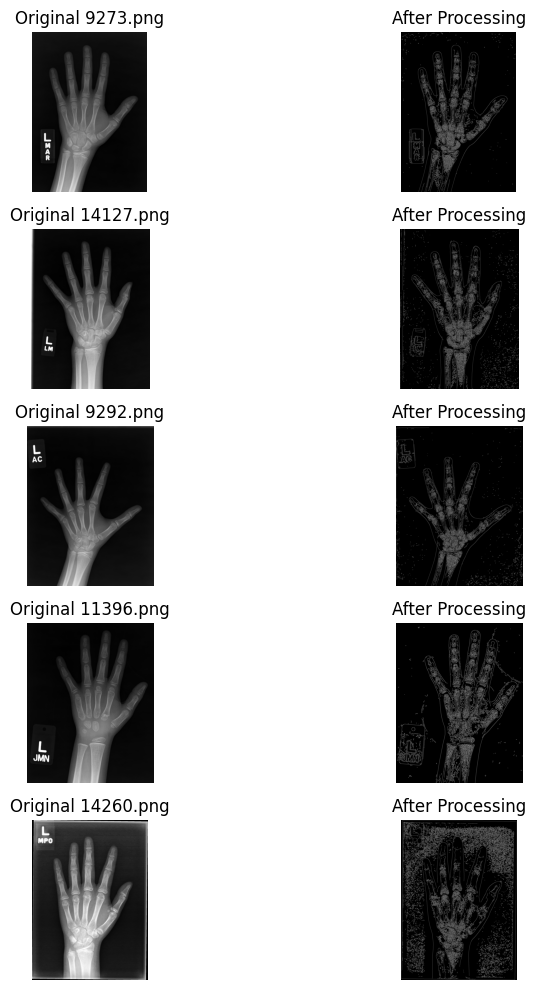

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# CLAHE function
def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(img)

# Canny with auto threshold
def auto_canny(image, sigma=0.33):
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return cv2.Canny(image, lower, upper)

# Preprocessing pipeline
def preprocess(img):
    # Step 1: CLAHE (clip=2, tile=8)
    img_clahe1 = apply_clahe(img, clip_limit=2, tile_grid_size=(8,8))

    # Step 2: Thresholding
    _, img_thresh = cv2.threshold(img_clahe1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Step 3: Median blur
    img_median = cv2.medianBlur(img_thresh, 5)

    # Step 4: Canny edge detection (edge enhancement)
    img_canny1 = auto_canny(img_median)

    # Step 5: CLAHE (clip=3, tile=8)
    img_clahe2 = apply_clahe(img_clahe1, clip_limit=3, tile_grid_size=(8,8))

    # Step 6: Gaussian blur
    img_gauss = cv2.GaussianBlur(img_clahe2, (5,5), 0)

    # Step 7: Final Canny edge detection
    img_canny2 = auto_canny(img_gauss)

    return img, img_canny2

# Load and process first 5 images from folder
def process_and_plot_images(folder_path):
    img_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg'))][:5]

    plt.figure(figsize=(10, 10))
    for i, file in enumerate(img_files):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        orig, processed = preprocess(img)

        # Plot original and processed
        plt.subplot(5, 2, 2*i + 1)
        plt.imshow(orig, cmap='gray')
        plt.title(f'Original {file}')
        plt.axis('off')

        plt.subplot(5, 2, 2*i + 2)
        plt.imshow(processed, cmap='gray')
        plt.title('After Processing')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 🔁 Call function with your folder path
folder = '/kaggle/input/rsna-bone-age/RSNA_train/images'  # ضع هنا مسار مجلد الصور
process_and_plot_images(folder)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

0: 640x480 1 bone, 39.7ms
Speed: 18.3ms preprocess, 39.7ms inference, 419.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 bone, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x512 1 bone, 37.3ms
Speed: 3.3ms preprocess, 37.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 1 bone, 6.6ms
Speed: 2.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x480 1 bone, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


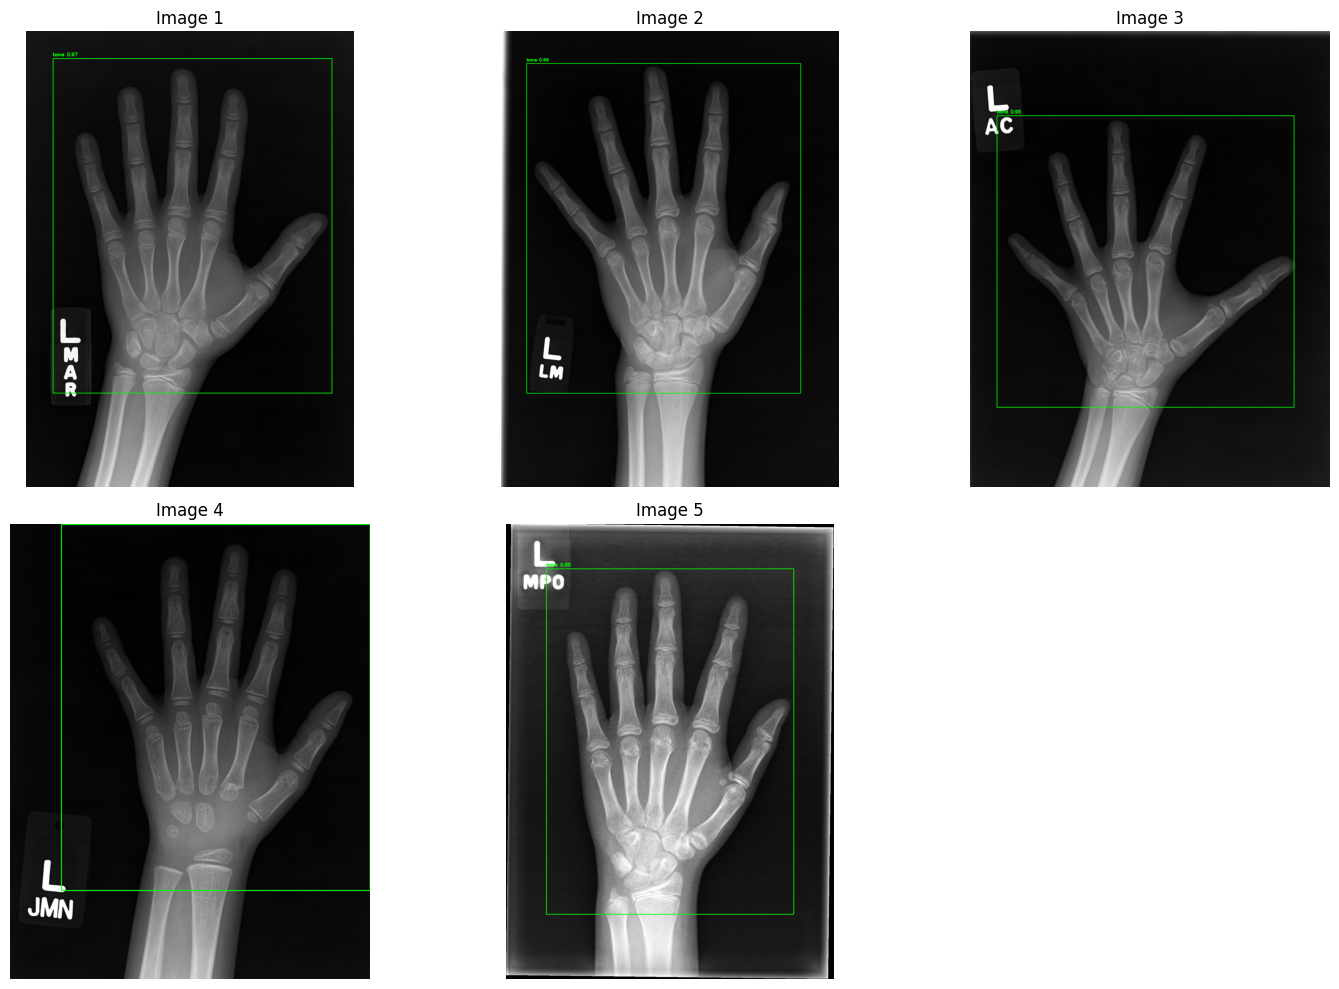

In [3]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os

# 🔁 تحميل الموديل المتدرب مسبقاً
model = YOLO("/kaggle/input/yolohand/pytorch/default/1/yolov8_trained.pt")  # ← حط هنا مسار الموديل

# 📁 مسار الصور
folder = "/kaggle/input/rsna-bone-age/RSNA_train/images"  # ← حط هنا مسار الصور
image_files = [f for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))][:5]

# 🔍 معالجة وعرض الصور
plt.figure(figsize=(15, 10))
for i, filename in enumerate(image_files):
    img_path = os.path.join(folder, filename)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 🧠 كشف الأجسام بالصورة
    results = model(img_rgb)[0]  # YOLOv8 يعطيك قائمة نتائج، بناخد أول وحدة

    # 🟥 رسم البوكسات
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # إحداثيات البوكس
        conf = float(box.conf[0])  # الثقة
        cls_id = int(box.cls[0])  # رقم الكلاس
        label = model.names[cls_id]
        
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_rgb, f'{label} {conf:.2f}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # 📊 عرض الصورة
    plt.subplot(2, 3, i + 1)
    plt.imshow(img_rgb)
    plt.title(f"Image {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()



0: 640x480 (no detections), 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 (no detections), 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x512 (no detections), 8.1ms
Speed: 3.4ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 (no detections), 6.9ms
Speed: 2.8ms preprocess, 6.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)

0: 640x480 (no detections), 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


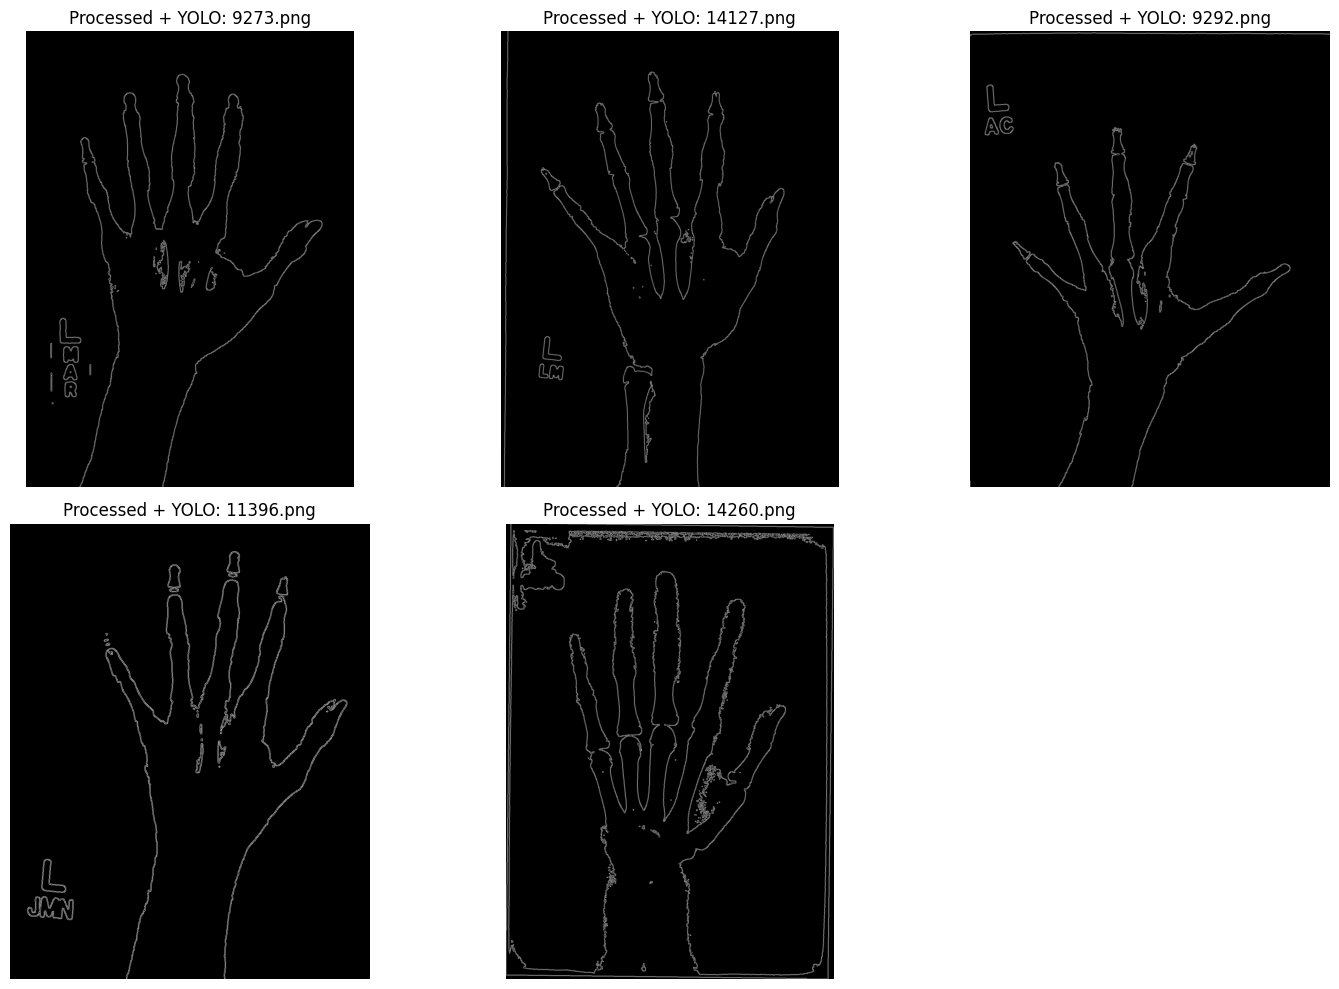

In [4]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# ⚙️ إعداد CLAHE
def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(img)

# ⚙️ Canny بعتبة تلقائية
def auto_canny(image, sigma=0.33):
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return cv2.Canny(image, lower, upper)

# 🔄 خطوات المعالجة
def preprocess(img):
    img = apply_clahe(img, clip_limit=2, tile_grid_size=(8,8))
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img = cv2.medianBlur(img, 5)
    img = auto_canny(img)
    img = apply_clahe(img, clip_limit=3, tile_grid_size=(8,8))
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = auto_canny(img)
    return img

# 🧠 تحميل موديل YOLO
model = YOLO("/kaggle/input/yolohand/pytorch/default/1/yolov8_trained.pt")

# 📁 تحميل الصور ومعالجتها
folder = "/kaggle/input/rsna-bone-age/RSNA_train/images"
image_files = [f for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))][:5]

plt.figure(figsize=(15, 10))

for i, filename in enumerate(image_files):
    img_path = os.path.join(folder, filename)
    img_orig = cv2.imread(img_path)
    gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

    # 🧪 Preprocessing
    processed = preprocess(gray)

    # YOLO يتوقع صورة ملونة → نرجع processed لصورة 3 قنوات
    processed_rgb = cv2.cvtColor(processed, cv2.COLOR_GRAY2RGB)

    # 🔍 كشف YOLO
    results = model(processed_rgb)[0]

    # 🟥 رسم البوكسات
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        cls_id = int(box.cls[0])
        label = model.names[cls_id]

        cv2.rectangle(processed_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(processed_rgb, f'{label} {conf:.2f}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # 📊 عرض
    plt.subplot(2, 3, i + 1)
    plt.imshow(processed_rgb)
    plt.title(f"Processed + YOLO: {filename}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [6]:
! pip install torch_ema

In [12]:
import os, time, torch, timm
import numpy as np
import pandas as pd
from PIL import Image
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from torch_ema import ExponentialMovingAverage
from ultralytics import YOLO
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from timm import create_model

In [2]:
# ==== Dataset with YOLO ====
class BoneAgeWithYoloDataset(Dataset):
    def __init__(self, df, root_dir, yolo_model, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
        self.yolo = YOLO(yolo_model)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.root_dir, str(row['ID']) + ".png")
        image = Image.open(image_path).convert("RGB")
        results = self.yolo(image, verbose=False)[0]

        if len(results.boxes) == 0:
            cropped = image
        else:
            box = results.boxes[0].xyxy[0].cpu().numpy().astype(int)
            x1, y1, x2, y2 = box
            cropped = image.crop((x1, y1, x2, y2))

        if self.transform:
            cropped = self.transform(cropped)

        label = torch.tensor(row['Boneage'], dtype=torch.float32)
        return cropped, label

In [18]:
# ==== Settings ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4
EPOCHS = 30
IMG_SIZE = 224

In [19]:
# ==== Augmentations ====
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.RandomRotation(15)], p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [20]:
# ==== Load Data ====
yolo_model_path = "/kaggle/input/yolohand/pytorch/default/1/yolov8_trained.pt"
raw_img_dir = "/kaggle/input/rsna-bone-age/RSNA_train/images"
df = pd.read_csv("/kaggle/input/rsna-bone-age/RSNA_Annotations/RSNA_Annotations/BONEAGE/boneage_train.csv")

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = BoneAgeWithYoloDataset(train_df, raw_img_dir, yolo_model_path, transform=train_transform)
val_dataset = BoneAgeWithYoloDataset(val_df, raw_img_dir, yolo_model_path, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [8]:
# ==== EfficientNet-B7 Model ====
class BoneAgeModelEfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = create_model("tf_efficientnet_b3_ns", pretrained=True, num_classes=0, global_pool="avg")
        self.head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.backbone.num_features, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.head(x).squeeze()


In [27]:
# ==== Training Components ====
model = BoneAgeModelEfficientNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)



In [10]:
pip install torchviz graphviz


Note: you may need to restart the kernel to use updated packages.


In [14]:
import torch
from torch import nn
from torchviz import make_dot

# مثال: موديل بسيط (استبدله بموديلك)


# 🧠 تعريف الموديل
model = BoneAgeModelEfficientNet()

# ⚠️ إنشاء input dummy بنفس حجم الصور اللي بتدخل الموديل
x = torch.randn(1, 3, 225, 225)  # ← عدل الأبعاد حسب الموديل بتاعك

# 🖼️ رسم مخطط الشبكة
y = model(x)
dot = make_dot(y, params=dict(model.named_parameters()))

# حفظ الرسم بحجم صغير
dot.format = 'png'
dot.directory = 'arch_plot'
dot.render('model_architecture', cleanup=True)


'arch_plot/model_architecture.png'

In [25]:
torch.cuda.empty_cache()

In [28]:
# ==== Training Loop ====
best_val_mae = float("inf")
early_stop_counter = 0
early_stop_patience = 7

train_mae_list, val_mae_list = [], []
train_r2_list, val_r2_list = [], []

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_preds, train_targets = [], []
    start_time = time.time()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_preds.extend(outputs.detach().cpu().numpy())
        train_targets.extend(labels.detach().cpu().numpy())

    train_mae = mean_absolute_error(train_targets, train_preds)
    train_r2 = r2_score(train_targets, train_preds)

    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_preds.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_mae = mean_absolute_error(val_targets, val_preds)
    val_r2 = r2_score(val_targets, val_preds)

    scheduler.step(val_mae)

    train_mae_list.append(train_mae)
    val_mae_list.append(val_mae)
    train_r2_list.append(train_r2)
    val_r2_list.append(val_r2)

    duration = time.time() - start_time
    print(f"[Epoch {epoch}] Train MAE: {train_mae:.2f} | R²: {train_r2:.3f} | Val MAE: {val_mae:.2f} | R²: {val_r2:.3f} | Duration: {duration:.2f}s")

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_efficientnetb7.pth")
        print("✅ Saved new best model.")
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("⛔ Early stopping triggered.")
            break


[Epoch 1] Train MAE: 40.29 | R²: -0.922 | Val MAE: 21.64 | R²: 0.580 | Duration: 1208.27s
✅ Saved new best model.
[Epoch 2] Train MAE: 15.30 | R²: 0.774 | Val MAE: 15.32 | R²: 0.780 | Duration: 1093.13s
✅ Saved new best model.
[Epoch 3] Train MAE: 12.92 | R²: 0.842 | Val MAE: 11.78 | R²: 0.873 | Duration: 1098.65s
✅ Saved new best model.
[Epoch 4] Train MAE: 11.94 | R²: 0.865 | Val MAE: 10.79 | R²: 0.893 | Duration: 1097.04s
✅ Saved new best model.
[Epoch 5] Train MAE: 11.37 | R²: 0.877 | Val MAE: 11.97 | R²: 0.871 | Duration: 1099.84s
[Epoch 6] Train MAE: 10.97 | R²: 0.885 | Val MAE: 11.96 | R²: 0.871 | Duration: 1112.08s
[Epoch 7] Train MAE: 10.64 | R²: 0.892 | Val MAE: 12.23 | R²: 0.865 | Duration: 1127.40s
[Epoch 8] Train MAE: 10.23 | R²: 0.900 | Val MAE: 10.40 | R²: 0.907 | Duration: 1120.49s
✅ Saved new best model.
[Epoch 9] Train MAE: 10.11 | R²: 0.902 | Val MAE: 9.64 | R²: 0.913 | Duration: 1111.95s
✅ Saved new best model.
[Epoch 10] Train MAE: 9.82 | R²: 0.908 | Val MAE: 11.37

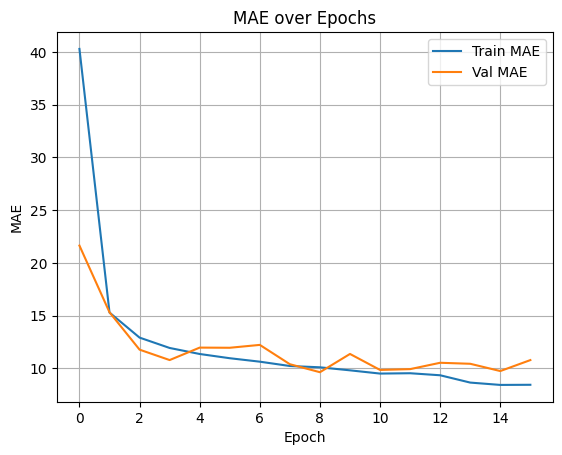

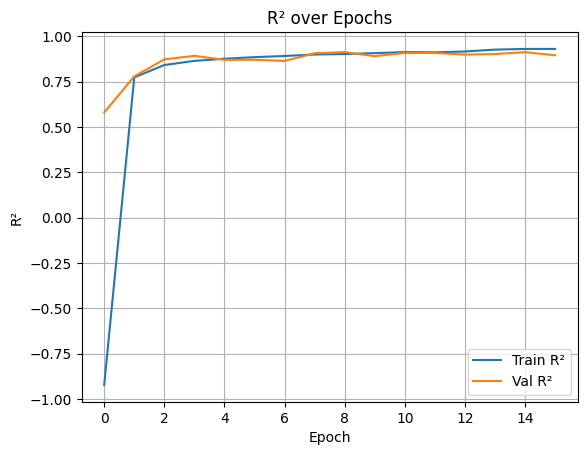

In [29]:
# ==== Plotting ====
plt.plot(train_mae_list, label="Train MAE")
plt.plot(val_mae_list, label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("MAE over Epochs")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(train_r2_list, label="Train R²")
plt.plot(val_r2_list, label="Val R²")
plt.xlabel("Epoch")
plt.ylabel("R²")
plt.title("R² over Epochs")
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [30]:
# ✅ كود تحسين تدريب موديل توقع عمر العظام باستخدام EfficientNet و YOLO لقص اليد
# يتضمن: EMA، Augmentations متقدمة، CosineAnnealingLR، Freezing مبدئي

In [31]:
# ==== Dataset with YOLO Hand Detection ====
class BoneAgeWithYoloDataset(Dataset):
    def __init__(self, df, root_dir, yolo_model, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
        self.yolo = YOLO(yolo_model)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.root_dir, str(row['ID']) + ".png")
        image = Image.open(image_path).convert("RGB")
        results = self.yolo(image, verbose=False)[0]

        if len(results.boxes) == 0:
            cropped = image
        else:
            box = results.boxes[0].xyxy[0].cpu().numpy().astype(int)
            x1, y1, x2, y2 = box
            cropped = image.crop((x1, y1, x2, y2))

        if self.transform:
            cropped = self.transform(cropped)

        label = torch.tensor(row['Boneage'], dtype=torch.float32)
        return cropped, label


In [32]:
# ==== Settings ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 30
IMG_SIZE = 320
best_val_mae = float('inf')

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.25, 0.25, 0.2, 0.05),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [42]:

# ==== Load Data ====
yolo_model_path = "/kaggle/input/yolohand/pytorch/default/1/yolov8_trained.pt"
raw_img_dir = "/kaggle/input/rsna-bone-age/RSNA_train/images"
df = pd.read_csv("/kaggle/input/rsna-bone-age/RSNA_Annotations/RSNA_Annotations/BONEAGE/boneage_train.csv")
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = BoneAgeWithYoloDataset(train_df, raw_img_dir, yolo_model_path, transform=train_transform)
val_dataset = BoneAgeWithYoloDataset(val_df, raw_img_dir, yolo_model_path, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [40]:
# ==== Model ====
class BoneAgeEffNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model("tf_efficientnet_b3_ns", pretrained=True, num_classes=0, global_pool="avg")
        self.head = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(self.backbone.num_features, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.head(x).squeeze()

model = BoneAgeEffNet().to(device)

# Freeze backbone first 3 epochs
for param in model.backbone.parameters():
    param.requires_grad = False

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
ema = ExponentialMovingAverage(model.parameters(), decay=0.995)

train_mae_list, val_mae_list, train_r2_list, val_r2_list = [], [], [], []

In [43]:
# ==== Training Loop ====
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0
    train_preds, train_targets = [], []
    start_time = time.time()

    if epoch == 4:
        for param in model.backbone.parameters():
            param.requires_grad = True

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        ema.update()

        train_preds.extend(outputs.detach().cpu().numpy())
        train_targets.extend(labels.detach().cpu().numpy())

    scheduler.step()
    train_mae = mean_absolute_error(train_targets, train_preds)
    train_r2 = r2_score(train_targets, train_preds)

    # ==== Validation ====
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad(), ema.average_parameters():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_preds.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_mae = mean_absolute_error(val_targets, val_preds)
    val_r2 = r2_score(val_targets, val_preds)

    train_mae_list.append(train_mae)
    val_mae_list.append(val_mae)
    train_r2_list.append(train_r2)
    val_r2_list.append(val_r2)
    epoch_duration = time.time() - start_time

    print(f"[Epoch {epoch}] Train MAE: {train_mae:.2f} | R²: {train_r2:.3f} | Val MAE: {val_mae:.2f} | R²: {val_r2:.3f} | Duration: {epoch_duration:.2f}s")

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), "best_efficientnet.pth")
        print("✅ Saved new best model.")

    if epoch >= 5 and val_mae > min(val_mae_list[-3:]):
        print("⛔ Early stopping triggered.")
        break


[Epoch 1] Train MAE: 112.40 | R²: -7.777 | Val MAE: 76.91 | R²: -3.527 | Duration: 1033.54s
✅ Saved new best model.
[Epoch 2] Train MAE: 84.84 | R²: -4.632 | Val MAE: 63.90 | R²: -2.440 | Duration: 1006.45s
✅ Saved new best model.
[Epoch 3] Train MAE: 74.32 | R²: -3.477 | Val MAE: 64.50 | R²: -2.473 | Duration: 1005.60s
[Epoch 4] Train MAE: 18.98 | R²: 0.638 | Val MAE: 18.97 | R²: 0.699 | Duration: 1163.93s
✅ Saved new best model.
[Epoch 5] Train MAE: 13.98 | R²: 0.816 | Val MAE: 19.21 | R²: 0.701 | Duration: 1174.40s
⛔ Early stopping triggered.
